In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import numba
from numba import jit
import sklearn.metrics
import sys

def calcscore(vec1,vec2):
     # centered dot product
     x = vec1-np.mean(vec1)
     y = vec2-np.mean(vec2)
     dst = np.dot(x,y)

     # centered correlation
     #dst = np.dot(vec1-np.mean(vec1),vec2-np.mean(vec2))/np.std(vec1-np.mean(vec1))/np.std(vec2-np.mean(vec2))
     return dst


def compute_scores(geneids2index,Xf):
        scores = {}
        k = 0
        for gs,gt in tqdm(orfsimilarities):
            if (gs in hugo2geneid)&(gt in hugo2geneid):
                orfsim = np.abs(orfsimilarities[(gs,gt)])
                if (k%1 == 0)|(orfsim>0.35): # for testing, we use only each 100th value
                    i1 = geneids2index.get(hugo2geneid[gs],0)
                    i2 = geneids2index.get(hugo2geneid[gt],0)
                    if i1*i2>0:
                        vec1 = Xf[i1,:]
                        vec2 = Xf[i2,:]
                        score = calcscore(vec1,vec2)
                        #pval = np.sum(random_dpvals>dst)/len(random_dpvals)
                        scores[(gs,gt)] = score
            k+=1
        return scores


In [44]:
#link_to_predict_list = ['gene_mf','gene_bp','gene_pathway']
link_to_predict_list = ['gene_bp']
#link_to_predict_list = ['gene_pathway']
pdtemp = pd.read_csv('tests/biomart_hugogeneid.tsv',sep='\t')
hugo2geneid = {row['HUGO']:row['GeneID'] for i,row in pdtemp.iterrows()}
geneid2hugo = {row['GeneID']:row['HUGO'] for i,row in pdtemp.iterrows()}


In [45]:
for link_to_predict in link_to_predict_list:
    func_similarity = pd.read_csv('trained_models/'+link_to_predict+'/'+link_to_predict+'_genefunction.tsv',sep='\t')
    Xf = func_similarity[func_similarity.columns[1:]].to_numpy()
    number_of_genes = Xf.shape[0]
    print(number_of_genes)

    t = np.array(func_similarity[func_similarity.columns[0]])
    geneids = [int(g[6:]) for g in t]
    geneids2index = {}
    index2geneid = {}
    for i,gid in enumerate(geneids):
        k = -1
        if 'Gene::'+str(gid) in t:
            k= np.where(t=='Gene::'+str(gid))[0][0]
        geneids2index[gid] = k
        index2geneid[k] = gid


18982


In [46]:
Xfc = Xf - np.mean(Xf,axis=1,keepdims=True)
Xdp = Xfc@Xfc.T
#Xdp = Xf@Xf.T

In [47]:
irx = np.argsort(-Xdp,axis=0)

In [66]:
n_neighb = 30
neareast_neighbours = {}
occurence = {}

# identify hubs
for i in range(Xdp.shape[0]):
    genesymbol = geneid2hugo[index2geneid[i]]
    l = [(geneid2hugo[index2geneid[irx[k,i]]],Xdp[i,irx[k,i]]) for k in range(n_neighb)]
    for k in range(n_neighb):
        g = geneid2hugo[index2geneid[irx[k,i]]]
        n = occurence.get(g,0)
        occurence[g] = n +1

# making neareast_neighbours and filter out hubs
for i in range(Xdp.shape[0]):
    genesymbol = geneid2hugo[index2geneid[i]]
    l = [(geneid2hugo[index2geneid[irx[k,i]]],Xdp[i,irx[k,i]]) for k in range(n_neighb) if occurence[geneid2hugo[index2geneid[irx[k,i]]]]<3000]
    neareast_neighbours[genesymbol] = l
    

In [77]:
#print(dict(sorted(occurence.items(), reverse=True, key=lambda item: item[1])))

SLIT2
BBS4
ITGB1
DPP4
RAC1
CDK5
CIB1
SFRP1
CDC42
WNT5A
NLGN1
WNT7A
VEGFA
SFRP2
ROCK1
PAFAH1B1
WNT3A
REN
PTK2
DMTN
MKKS
TRPV4
CLASP2
TIAM1
SEMA5A
IFT88
RHOA
FGF10


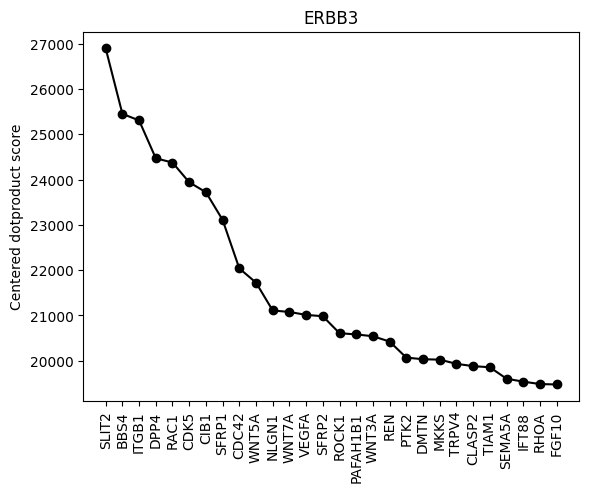

In [76]:
gene = 'WNT1'
#gene = 'PARP1'
#gene = 'OR51E2'
gene = 'OR2A2'
#gene = 'SLC7A9'
gene = 'CDK1'
gene = 'ERBB3'
l = neareast_neighbours[gene]
vals = []
genes = []
for t in l:
    print(t[0])
    genes.append(t[0])
    vals.append(t[1])
plt.plot(vals,'ko-')
plt.xticks(ticks=np.arange(0,len(genes)),labels=genes,rotation=90)
plt.title(gene)
plt.ylabel('Centered dotproduct score')
plt.show()